<a href="https://colab.research.google.com/github/Pardhu156/Virtual-Clothes-Changing-using-SAM-Segmentation-Stable-Diffusion/blob/main/Cloths_Changing_(Segmentation_%2B_Stable_Diffusion).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q regex tqdm
!pip install -q diffusers transformers accelerate scipy
!pip install -q -U xformers
!pip install -q opencv-python

#Segment Anything Models(SAM):
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q pycocotools matplotlib onnxruntime onnx

  Preparing metadata (setup.py) ... done


In [ ]:
!pip uninstall torchvision

Found existing installation: torchvision 0.22.0
Uninstalling torchvision-0.22.0:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/torchvision-0.22.0.dist-info/*
    /usr/local/lib/python3.11/dist-packages/torchvision.libs/libcudart.45e7f3ed.so.12
    /usr/local/lib/python3.11/dist-packages/torchvision.libs/libjpeg.c0b0716f.so.8
    /usr/local/lib/python3.11/dist-packages/torchvision.libs/libnvjpeg.e5f20359.so.12
    /usr/local/lib/python3.11/dist-packages/torchvision.libs/libpng16.41d77625.so.16
    /usr/local/lib/python3.11/dist-packages/torchvision.libs/libsharpyuv.d7dafb46.so.0
    /usr/local/lib/python3.11/dist-packages/torchvision.libs/libwebp.ad67f466.so.7
    /usr/local/lib/python3.11/dist-packages/torchvision.libs/libz.f537e57c.so.1
    /usr/local/lib/python3.11/dist-packages/torchvision/*
Proceed (Y/n)? Y
  Successfully uninstalled torchvision-0.22.0


In [ ]:
!pip install torchvision

  Using cached torchvision-0.22.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
Using cached torchvision-0.22.0-cp311-cp311-manylinux_2_28_x86_64.whl (7.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0 which is incompatible.


In [ ]:
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor
import PIL, cv2
from PIL import Image
from io import BytesIO
from IPython.display import display
import base64,json,requests
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
import sys

from segment_anything import sam_model_registry,SamAutomaticMaskGenerator,SamPredictor

**Download Segment Anything Checkpoint**

Download the checkpoint file called **sam_vit_h_4b8939.pth**
and put it on the same folder where your notebook is

**Current Download link:**
https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
(if it doesn't work, it may have moved somewhere else, check instructions at https://github.com/facebookresearch/segment-anything )

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2025-05-01 19:33:24--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.65.229.121, 18.65.229.95, 18.65.229.89, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.65.229.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.2’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   149MB/s    in 22s     

utime(sam_vit_h_4b8939.pth.2): No such file or directory
2025-05-01 19:33:46 (112 MB/s) - ‘sam_vit_h_4b8939.pth.2’ saved [2564550879/2564550879]



##Importing and Setting up of Stable Diffuser Model

In [ ]:
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler
model_dir="stabilityai/stable-diffusion-2-inpainting"
scheduler=EulerDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")
pipe=StableDiffusionInpaintPipeline.from_pretrained(model_dir,
                                                   scheduler=scheduler,
                                                   revision="fp16",
                                                   torch_dtype=torch.float16)
pipe=pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


##Photo and Processing

Source Image Size: (3923, 5811)
Source Image Size: (512, 512)


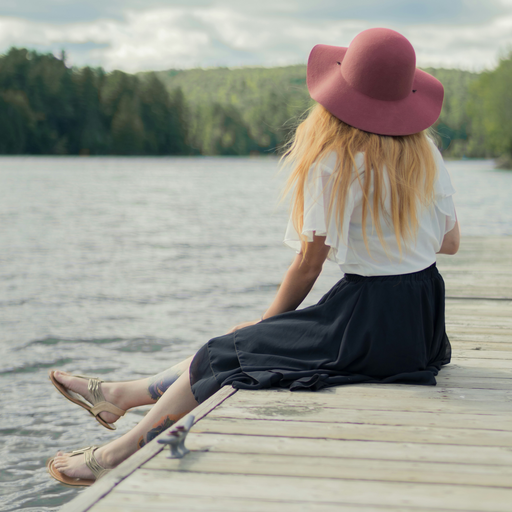

In [ ]:
source_image=Image.open('Cloths_Changing.jpg')
target_width,target_height=512,512
width, height = source_image.size
print(f"Source Image Size: {source_image.size}")
source_image=source_image.crop((0,height-width,width,height))
source_image=source_image.resize((target_width,target_height),Image.LANCZOS)
print(f"Source Image Size: {source_image.size}")
segmentation_image=asarray(source_image)
display(source_image)

##Initialize and Run Segment Anything Model(SAM)

In [ ]:
sam_checkpoint='sam_vit_h_4b8939.pth'
model_type='vit_h'
device='cuda'
sam=sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam=sam.to(device)
mask_generator=SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.99, # A filtering threshold in [0,1], using the model's predicted mask quality.High value for less masks
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,)

In [ ]:
masks=mask_generator.generate(segmentation_image)
print(f"No of masks: {len(masks)}")
print(masks[0].keys())

No of masks: 11
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


##Function that superimposes Masks on Image (GPT)

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return

    # Sort masks by area in descending order
    sorted_anns = sorted(enumerate(anns), key=(lambda x: x[1]['area']), reverse=True)
    ax = plt.gca()

    # Disable autoscale to keep the image size consistent
    ax.set_autoscale_on(False)

    # Iterate through each mask and display it on top of the original image
    for original_idx, ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))

        # Generate a random color for the mask
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]

        # Blend the mask with the image, using 0.35 as the alpha value for transparency
        ax.imshow(np.dstack((img, m*0.35)))

        # Find contours of the mask to compute the centroid
        contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = contours[0]
            M = cv2.moments(cnt)

            # Compute the centroid of the mask if the moment is non-zero
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])

                # Display the original index number (1-based) at the centroid of the mask
                # The text is white, bold, and has a font size of 16
                ax.text(cx, cy, str(original_idx), color='white', fontsize=16, ha='center', va='center', fontweight='bold')

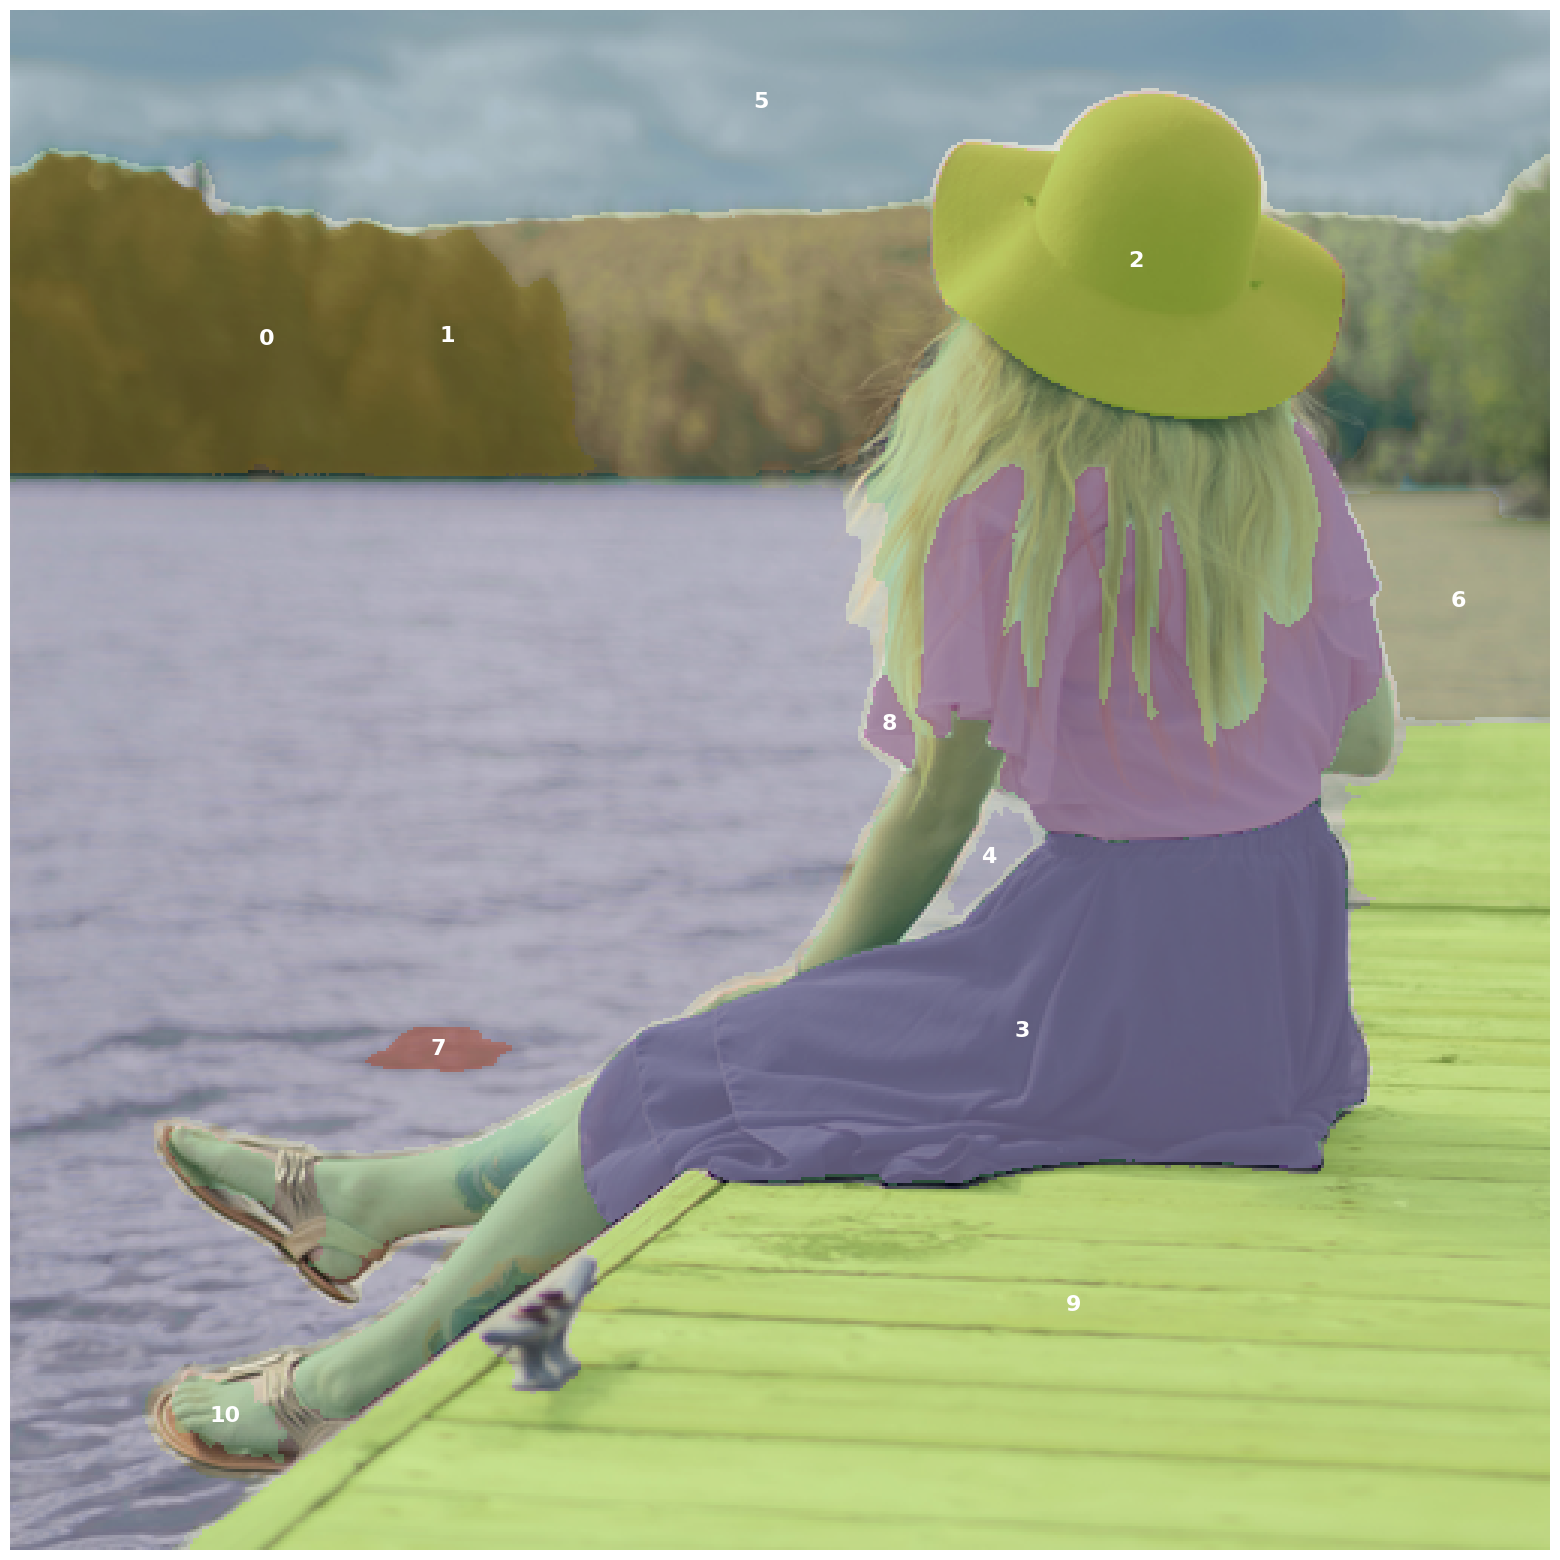

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(source_image)
show_anns(masks)
plt.axis('off')
plt.show()

In [ ]:
for i,value in enumerate(masks):
  print(f"{i}: Area: {value['area']} | IoU: {value['predicted_iou']}")   #If IoU not close to 1 means bad segmenatation

0: Area: 16207 | IoU: 1.0115402936935425
1: Area: 26585 | IoU: 1.0005792379379272
2: Area: 10621 | IoU: 1.0191075801849365
3: Area: 21816 | IoU: 1.0172491073608398
4: Area: 66850 | IoU: 1.0144931077957153
5: Area: 29785 | IoU: 1.012594223022461
6: Area: 4159 | IoU: 1.0037367343902588
7: Area: 506 | IoU: 0.9955280423164368
8: Area: 11134 | IoU: 0.9937789440155029
9: Area: 54706 | IoU: 1.0425183773040771
10: Area: 63234 | IoU: 1.0087398290634155


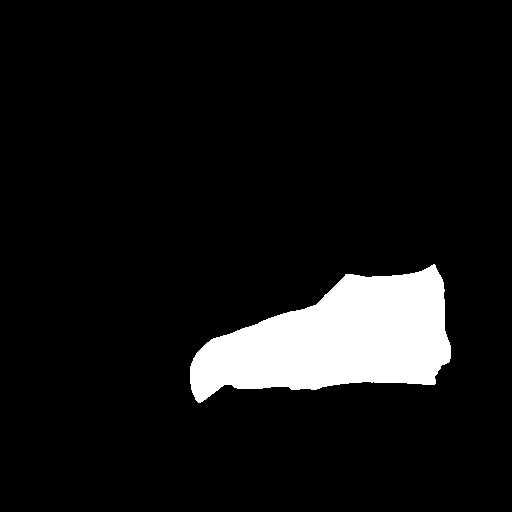

In [ ]:
mask_index=3
segmentation_mask=masks[mask_index]['segmentation']
stable_diffusion_mask=PIL.Image.fromarray(segmentation_mask)
display(stable_diffusion_mask)

In [ ]:
num_images_per_prompt=4
inpainting_prompts=["a skirt full of text", "red flowers","blue flowers","a zebra skirt"]
generator=torch.Generator(device='cuda').manual_seed(155)
encoded_images=[]
for i in range(num_images_per_prompt):
  image = pipe(prompt=inpainting_prompts[i], guidance_scale=10, num_inference_steps=80, generator=generator, image=source_image, mask_image=stable_diffusion_mask).images[0]
  encoded_images.append(image)   #guidance_scale , num_interference_steps can be changed for better results

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt
import math
import copy

def create_image_grid(original_image, images, names, rows=None, columns=None):
    names = copy.copy(names)
    images = copy.copy(images)

    assert len(images) == len(names), "Number of images and names should be equal"

    # Insert original image and label
    images.insert(0, original_image)
    names.insert(0, "Original")

    total_images = len(images)

    # Auto-calculate grid size if not provided
    if rows is None or columns is None:
        columns = min(3, total_images)
        rows = math.ceil(total_images / columns)

    fig, axes = plt.subplots(rows, columns, figsize=(4 * columns, 4 * rows))

    # Make axes iterable even if 1D
    axes = axes.flatten() if hasattr(axes, "flatten") else [axes]

    for idx in range(rows * columns):
        ax = axes[idx]
        if idx < total_images:
            ax.imshow(images[idx])
            ax.set_title(names[idx])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

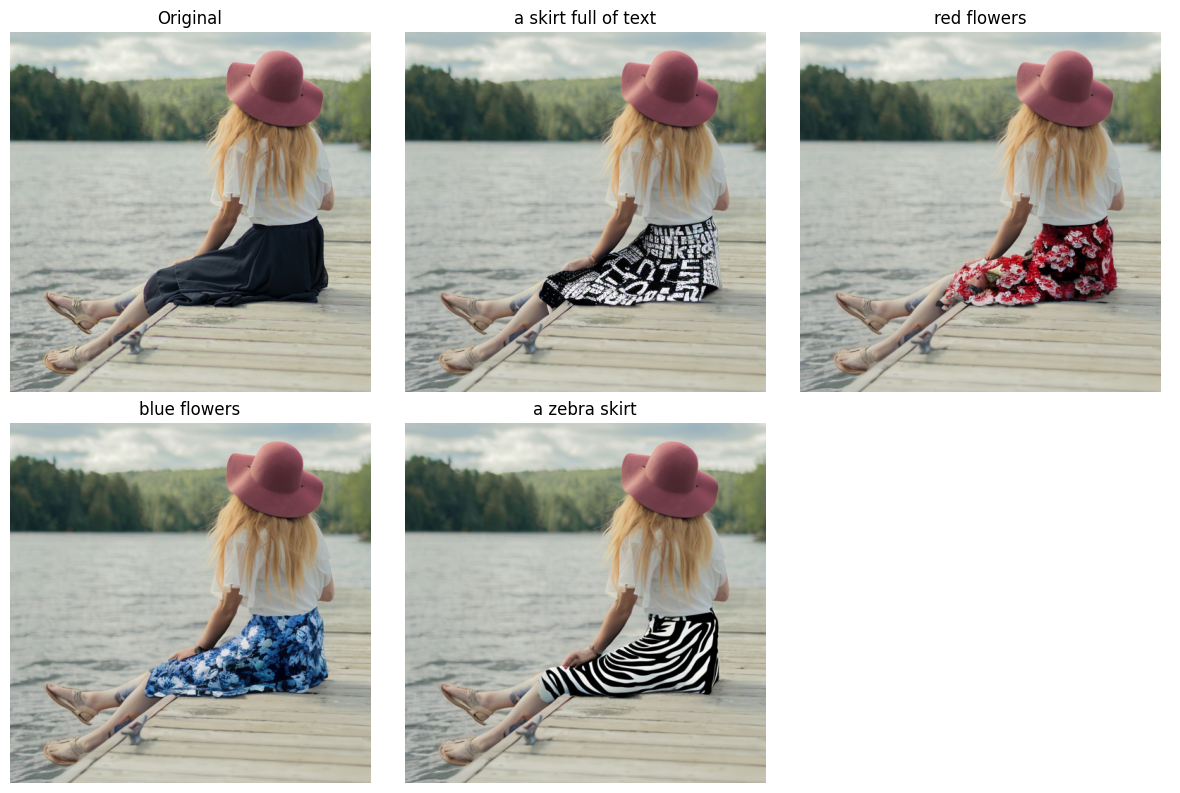

In [ ]:
create_image_grid(source_image, encoded_images, inpainting_prompts, 2, 3)